In [1]:
import numpy as np
import torch
import pandas as pd
import random
from sklearn.preprocessing import MinMaxScaler
from sanfis import SANFIS
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from typing import Optional
from pandas.core.frame import DataFrame
import os

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

df = pd.read_excel("../data/survey_scenarios.xlsx", header=0)

minmax_scaler = MinMaxScaler()
columns_to_scale = ['Last Avg Tensiometer', 'Predicted Avg Tensiometer', 'Predicted Rain Amount', 'Predicted Max Temperature']
df2 = df.copy()
df2[columns_to_scale] = minmax_scaler.fit_transform(df2[columns_to_scale]).round(3)

decision_mapping = {
    "Not Recommended": 0.0,
    "Half Turn": 325.0,
    "Single Turn": 650.0,
    "Double Turn": 1300.0
}
df2['Decision'] = df2['Decision'].map(decision_mapping)

X = df2[columns_to_scale].values
y = df2['Decision'].values.reshape(-1, 1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32)


MEMBFUNCS = [
    {'function': 'bell', 'n_memb': 3,
     'params': {'c': {'value': [0.2, 0.5, 0.8], 'trainable': True},
                'a': {'value': [0.2, 0.15, 0.1], 'trainable': True},
                'b': {'value': [2.0, 2.5, 3.0], 'trainable': True}}}
] * 4

model = SANFIS(membfuncs=MEMBFUNCS, n_input=4, scale='Std')
loss_function = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.00003)

history = model.fit(train_data=[X_train_tensor, y_train_tensor],
                    valid_data=[X_valid_tensor, y_valid_tensor],
                    optimizer=optimizer,
                    loss_function=loss_function,
                    epochs=2000)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_pred = model.predict(X_tensor)

Train s-anfis on 46 samples, validate on 20 samples


Training Loop: 100%|##########| 2000.0/2000 [00:09<00:00, 201.34epochs/s, train_loss=0.555, valid_loss=1.52]


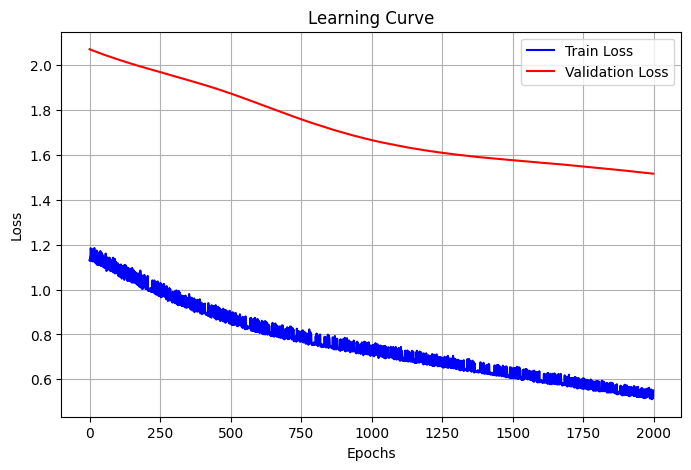

In [2]:
train_loss = history['train_curve']
valid_loss = history['valid_curve']

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(valid_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid()

plt.show()

In [3]:
def plt_prediction(y, y_pred, title='', save_path: Optional[str] = None):
    f, axs = plt.subplots(2, 1, figsize=(8, 6))
    f.subplots_adjust(hspace=0.3)
    f.suptitle(f'{title}', size=16)
    y, y_pred = np.array(y), np.array(y_pred)  # both to np array
    ymin, ymax = min(min(y), min(y_pred)), max(max(y), max(y_pred))
    max(max(y), max(y_pred))
    axs[0].plot(y, color='k')
    axs[0].plot(y_pred, alpha=1.0, color='orange')
    axs[0].grid(True)
    axs[0].set_ylim((ymin, ymax))
    axs[0].tick_params(axis='x', labelsize=14)
    axs[0].tick_params(axis='y', labelsize=14)
    n_bins = int(len(y) / 20)
    limit = max(abs(y - y_pred))[0]
    axs[1].hist(y - y_pred, bins=n_bins, align='mid',
                range=[-limit, limit], facecolor='gray')
    axs[1].tick_params(axis='x', labelsize=14)
    axs[1].tick_params(axis='y', labelsize=14)
    axs[1].grid(True)
    f.legend([r'$y_t$', r'$\hat{y}_t$', r'$y_t - \hat{y}_t$'],
             fontsize=10, ncol=5, loc='upper center', prop={'size': 20})

    plt.show()

    if save_path != None:
        f.savefig(os.path.join(save_path),
                  bbox_inches='tight', pad_inches=0)


def plt_learningcurves(history: DataFrame, title: Optional[str] = None, save_path: Optional[str] = None):
    plot = history.plot(figsize=(8, 5), logy=True)
    if title:
        plt.title(title)
    plt.grid(True)
    plt.show()

    if save_path != None:
        fig = plot.get_figure()
        fig.savefig(os.path.join(save_path),
                    bbox_inches='tight', pad_inches=0)

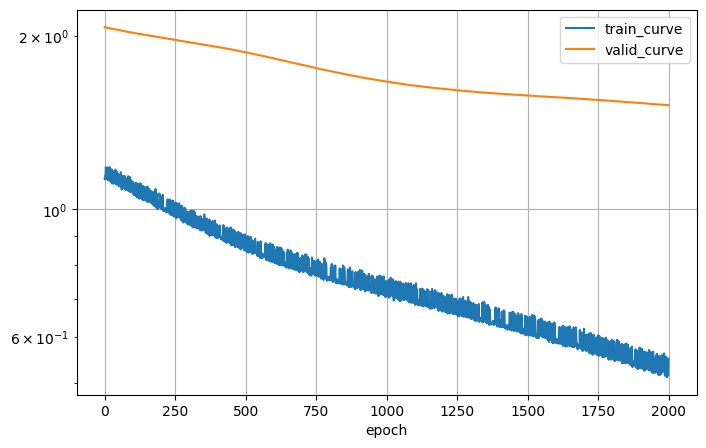

C:\Users\silve\AppData\Local\Temp\ipykernel_7948\4190167818.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y, y_pred = np.array(y), np.array(y_pred)  # both to np array


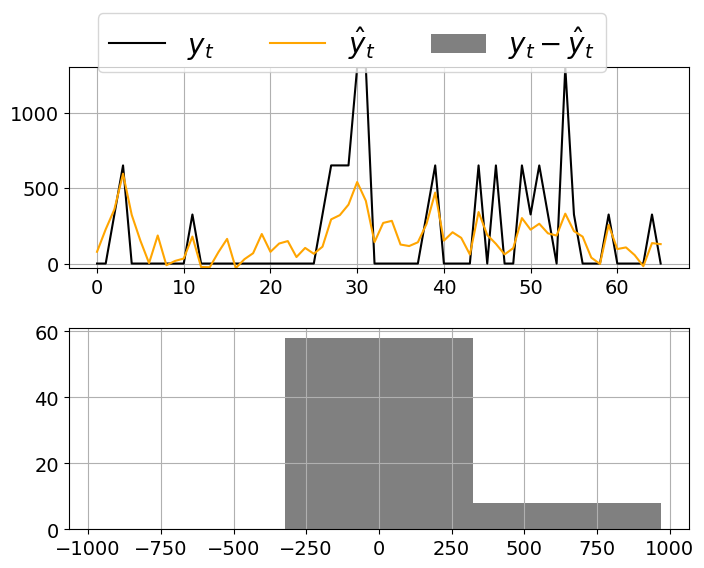

In [4]:
plt_learningcurves(history)

plt_prediction(y, y_pred)

In [5]:
new_X = np.array([[400.0, 500.0, 0.0, 30.0]])
new_X_df = pd.DataFrame(new_X, columns=columns_to_scale)
new_X_scaled = minmax_scaler.transform(new_X_df)
new_X_tensor = torch.tensor(new_X_scaled, dtype=torch.float32)

y_pred_new = model.predict(new_X_tensor)

print(f"Valore predetto: {y_pred_new.item():.3f}")

Valore predetto: 314.514


In [6]:
import numpy as np
import torch
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sanfis import SANFIS
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# Caricamento dati
df = pd.read_excel("../data/survey_scenarios.xlsx", header=0)

# Normalizzazione
minmax_scaler = MinMaxScaler()
columns_to_scale = ['Last Avg Tensiometer', 'Predicted Avg Tensiometer', 'Predicted Rain Amount', 'Predicted Max Temperature']
df[columns_to_scale] = minmax_scaler.fit_transform(df[columns_to_scale])

# Mappatura delle decisioni
decision_mapping = {
    "Not Recommended": 0.0,
    "Half Turn": 325.0,
    "Single Turn": 650.0,
    "Double Turn": 1300.0
}
df['Decision'] = df['Decision'].map(decision_mapping)

X = df[columns_to_scale].values
y = df['Decision'].values.reshape(-1, 1)

# Impostazione della k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

# Parametri delle membership function
MEMBFUNCS = [
    {'function': 'bell', 'n_memb': 3,
     'params': {'c': {'value': [0.2, 0.5, 0.8], 'trainable': True},
                'a': {'value': [0.2, 0.15, 0.1], 'trainable': True},
                'b': {'value': [2.0, 2.5, 3.0], 'trainable': True}}}
] * 4

loss_function = torch.nn.MSELoss(reduction='mean')
learning_rate = 0.0001
epochs = 500
all_fold_losses = []

# Esecuzione della k-fold cross-validation
for fold, (train_idx, valid_idx) in enumerate(kfold.split(X)):
    print(f"Fold {fold + 1} / {kfold.get_n_splits()}")

    # Creazione dei dati di train e validation per questa fold
    X_train, X_valid = X[train_idx], X[valid_idx]
    y_train, y_valid = y[train_idx], y[valid_idx]

    # Conversione in tensori
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32)

    # Creazione nuovo modello per ogni fold
    model = SANFIS(membfuncs=MEMBFUNCS, n_input=4, scale='Std')
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

    # Training del modello su questa fold
    history = model.fit(train_data=[X_train_tensor, y_train_tensor],
                        valid_data=[X_valid_tensor, y_valid_tensor],
                        optimizer=optimizer,
                        loss_function=loss_function,
                        epochs=epochs)

    final_loss = history['valid_curve'].iloc[-1]
    all_fold_losses.append(final_loss)

# Stampa dei risultati finali
print("\nRisultati della k-fold cross-validation:")
print(f"Loss media: {np.mean(all_fold_losses):.4f}")
print(f"Deviazione standard: {np.std(all_fold_losses):.4f}")

Fold 1 / 5
Train s-anfis on 52 samples, validate on 14 samples


Training Loop: 100%|##########| 500.0/500 [00:03<00:00, 151.37epochs/s, train_loss=0.486, valid_loss=1.3] 


Fold 2 / 5
Train s-anfis on 53 samples, validate on 13 samples


Training Loop: 100%|##########| 500.0/500 [00:03<00:00, 148.86epochs/s, train_loss=0.447, valid_loss=0.638]


Fold 3 / 5
Train s-anfis on 53 samples, validate on 13 samples


Training Loop: 100%|##########| 500.0/500 [00:03<00:00, 147.18epochs/s, train_loss=1.08, valid_loss=0.913] 


Fold 4 / 5
Train s-anfis on 53 samples, validate on 13 samples


Training Loop: 100%|##########| 500.0/500 [00:03<00:00, 150.41epochs/s, train_loss=0.445, valid_loss=1.09]


Fold 5 / 5
Train s-anfis on 53 samples, validate on 13 samples


Training Loop: 100%|##########| 500.0/500 [00:03<00:00, 147.37epochs/s, train_loss=0.453, valid_loss=0.48] 


Risultati della k-fold cross-validation:
Loss media: 0.8793
Deviazione standard: 0.2958


In [7]:
# Creazione di un modello finale
final_model = SANFIS(membfuncs=MEMBFUNCS, n_input=4, scale='Std')
final_optimizer = torch.optim.Adam(params=final_model.parameters(), lr=0.0001)

# Conversione dei dati completi in tensori
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Addestramento su tutti i dati
history = final_model.fit(train_data=[X_tensor, y_tensor],
                valid_data=[X_tensor, y_tensor],
                optimizer=final_optimizer,
                loss_function=torch.nn.MSELoss(reduction='mean'),
                epochs=2000)


Train s-anfis on 66 samples, validate on 66 samples


Training Loop: 100%|##########| 2000.0/2000 [00:16<00:00, 123.41epochs/s, train_loss=0.764, valid_loss=0.891]


In [8]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_pred = model.predict(X_tensor)

In [9]:
y_pred

tensor([[  54.3302],
        [ 133.6292],
        [ 364.1401],
        [ 587.0759],
        [ 344.3229],
        [  64.4953],
        [-138.2731],
        [  71.8935],
        [ -44.7109],
        [ 140.6253],
        [  23.9211],
        [ 220.4138],
        [ -19.7784],
        [ -37.9642],
        [  37.1768],
        [ 175.8929],
        [ -23.3054],
        [ -31.6111],
        [   5.6597],
        [ 127.6554],
        [ 194.4261],
        [ 199.6647],
        [ 224.3268],
        [ 160.2760],
        [  26.0322],
        [ 106.1714],
        [ 231.1604],
        [ 405.8076],
        [ 517.8584],
        [ 697.9646],
        [ 638.3915],
        [ 638.6442],
        [ 458.9460],
        [ 219.3109],
        [  52.8278],
        [ 178.1255],
        [ 230.3190],
        [ 231.5158],
        [ 231.3327],
        [ 249.3513],
        [ 228.2925],
        [ 201.4582],
        [  59.0574],
        [  56.0507],
        [ 111.5301],
        [  42.1748],
        [ 298.1490],
        [ 188